In [1]:
# --- CELL 1: SETUP WORKSPACE & IMPORTS ---
import os
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# 1. Get the current directory
BASE_DIR = os.getcwd()
print(f"📂 Current Working Directory: {BASE_DIR}")

# 2. Define the internal folders for our new dataset and model
DATA_DIR = os.path.join(BASE_DIR, 'coco_data')
IMAGE_DIR = os.path.join(DATA_DIR, 'val2017')
WORKING_DIR = os.path.join(BASE_DIR, 'working')

# 3. Create the folders safely
for directory in [DATA_DIR, WORKING_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"✅ Created directory: {directory}")
    else:
        print(f"✅ Directory already exists: {directory}")

print("\nCell 1 Complete: Workspace is ready for MS COCO!")

📂 Current Working Directory: c:\Users\Admin\Desktop\Aniket_Aman\Team4
✅ Directory already exists: c:\Users\Admin\Desktop\Aniket_Aman\Team4\coco_data
✅ Directory already exists: c:\Users\Admin\Desktop\Aniket_Aman\Team4\working

Cell 1 Complete: Workspace is ready for MS COCO!


In [2]:
# --- CELL 2: DOWNLOAD & EXTRACT MS COCO ---
import requests
import zipfile

def download_and_extract_coco(url, zip_filename, target_dir):
    zip_path = os.path.join(DATA_DIR, zip_filename)
    
    # Check if we already extracted it
    if os.path.exists(target_dir):
        print(f"✅ Data already present at: {target_dir}")
        return

    # 1. Download with a progress bar
    print(f"Downloading {zip_filename}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(zip_path, 'wb') as file, tqdm(
        desc=zip_filename, total=total_size, unit='iB', unit_scale=True
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
            
    # 2. Extract the zip file
    print(f"Extracting {zip_filename} (This might take a minute)...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
        
    # 3. Clean up the zip file to save hard drive space
    os.remove(zip_path)
    print(f"✅ Extraction complete for {zip_filename}!")

# Official MS COCO URLs
coco_images_url = "http://images.cocodataset.org/zips/val2017.zip"
coco_annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# The target directories we expect after extraction
val_images_dir = os.path.join(DATA_DIR, 'val2017')
annotations_dir = os.path.join(DATA_DIR, 'annotations')

# Run the downloader
download_and_extract_coco(coco_images_url, 'val2017.zip', val_images_dir)
download_and_extract_coco(coco_annotations_url, 'annotations.zip', annotations_dir)

print("\nCell 2 Complete: MS COCO dataset is ready!")

✅ Data already present at: c:\Users\Admin\Desktop\Aniket_Aman\Team4\coco_data\val2017
✅ Data already present at: c:\Users\Admin\Desktop\Aniket_Aman\Team4\coco_data\annotations

Cell 2 Complete: MS COCO dataset is ready!


In [3]:
# --- CELL 3: TEXT PROCESSING ---
import json
import os
import string
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

print("Parsing MS COCO JSON Annotations...")

# 1. Load the MS COCO validation annotations
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations', 'captions_val2017.json')

with open(ANNOTATIONS_FILE, 'r') as f:
    coco_data = json.load(f)

# 2. Map MS COCO's internal image IDs to their actual filenames
id_to_filename = {}
for img in coco_data['images']:
    id_to_filename[img['id']] = img['file_name']

# 3. Map filenames to their captions and clean the text
mapping = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    filename = id_to_filename[img_id]
    caption = ann['caption']
    
    if filename not in mapping:
        mapping[filename] = []
        
    # Clean text: lowercase, remove punctuation, add start/end tokens
    caption = caption.lower().translate(str.maketrans('', '', string.punctuation))
    caption = f"startseq {caption} endseq"
    mapping[filename].append(caption)

print(f"✅ Total images found in COCO validation: {len(mapping)}")

# 4. Subset the dataset to just 5000 images
subset_size = 5000
all_filenames = list(mapping.keys())
subset_filenames = all_filenames[:subset_size]

# Create a new mapping dictionary with only our 5000 images
subset_mapping = {k: mapping[k] for k in subset_filenames}
print(f"🚀 Speed Hack applied! We will only train on {len(subset_mapping)} images.")

# 5. Tokenize the text (Convert words to numbers)
all_captions = []
for key in subset_mapping:
    for cap in subset_mapping[key]:
        all_captions.append(cap)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(cap.split()) for cap in all_captions)

# 6. Save the tokenizer and our new subset mapping
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open(os.path.join(WORKING_DIR, 'subset_mapping.pkl'), 'wb') as f:
    pickle.dump(subset_mapping, f)

print(f"✅ Vocabulary Size for subset: {vocab_size} words")
print(f"✅ Longest Caption: {max_length} words")
print("\nCell 3 Complete: Text processing finished!")

Parsing MS COCO JSON Annotations...
✅ Total images found in COCO validation: 5000
🚀 Speed Hack applied! We will only train on 5000 images.
✅ Vocabulary Size for subset: 7324 words
✅ Longest Caption: 51 words

Cell 3 Complete: Text processing finished!


In [ ]:
# --- CELL 4: IMAGE FEATURE EXTRACTION (MobileNetV2) CNN ---
import os
import pickle
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tqdm import tqdm

print("Loading MobileNetV2 model for feature extraction...")

# 1. Load the MobileNetV2 model
# We use include_top=False and pooling='avg' to get a 1280-number vector directly!
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
encoder_model = Model(inputs=base_model.input, outputs=base_model.output)

features_path = os.path.join(WORKING_DIR, 'features.pkl')

# 2. Extract Features for our 5000 subset images
if os.path.exists(features_path):
    print(f"✅ Features already extracted! Loading from: {features_path}")
    with open(features_path, 'rb') as f:
        features = pickle.load(f)
    print(f"Loaded features for {len(features)} images.")
else:
    print(f"Extracting features from {len(subset_mapping)} images... (This will be FAST!)")
    features = {}
    
    # Loop through the images
    for img_name in tqdm(subset_mapping.keys()):
        # Construct full image path
        img_path = os.path.join(IMAGE_DIR, img_name)
        
        # MobileNetV2 expects 224x224 images
        image = load_img(img_path, target_size=(224, 224))
        
        # Convert and preprocess
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        # Extract the 1280-dimensional feature vector
        feature = encoder_model.predict(image, verbose=0)
        
        # Store it using the exact filename as the key
        features[img_name] = feature
        
    # Save the dictionary to disk
    with open(features_path, 'wb') as f:
        pickle.dump(features, f)
    print(f"\n✅ Extraction complete! Saved features for {len(features)} images.")

print("\nCell 4 Complete: The AI's 'eyes' are ready!")

Loading MobileNetV2 model for feature extraction...


C:\Users\Admin\AppData\Local\Temp\ipykernel_16020\1199594861.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


✅ Features already extracted! Loading from: c:\Users\Admin\Desktop\Aniket_Aman\Team4\working\features.pkl
Loaded features for 5000 images.

Cell 4 Complete: The AI's 'eyes' are ready!


In [5]:
# --- CELL 5: MODEL ARCHITECTURE & GENERATOR ---
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

print("Building the upgraded AI Brain...")

# 1. Define the AI Brain (MobileNetV2 + LSTM)
def build_model(vocab_size, max_length):
    # Pathway 1: Processing the Image Features (1280 dimensions from MobileNetV2)
    inputs1 = Input(shape=(1280,), name="Image_Features")
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Pathway 2: Processing the Text Sequences
    inputs2 = Input(shape=(max_length,), name="Text_Sequences")
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)

    # Pathway 3: Merging both together
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name="Next_Word_Prediction")(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

# 2. Define the Data Generator (Tuple Fix Included!)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for cap in captions:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Ensure we grab the exact feature vector shape
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            
            # Yielding a tuple () for strict TensorFlow compatibility
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

model = build_model(vocab_size, max_length)

# Print a neat map of the network
model.summary()

print("\nCell 5 Complete: Architecture built and Generator is ready!")

Building the upgraded AI Brain...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Text_Sequences      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Features      │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 51, 256)   │  1,874,944 │ Text_Sequences[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ Image_Features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 51, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 51)        │          0 │ Text_Sequences[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    327,936 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Next_Word_Predicti… │ (None, 7324)      │  1,882,268 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,676,252 (17.84 MB)

 Trainable params: 4,676,252 (17.84 MB)

 Non-trainable params: 0 (0.00 B)


Cell 5 Complete: Architecture built and Generator is ready!


In [6]:
# --- CELL 6: TRAINING ---
import os

print("Preparing MS COCO subset for training...")

# 1. Split the subset into Training (90%) and Testing (10%)
valid_keys = list(subset_mapping.keys())
split = int(len(valid_keys) * 0.90)

train_keys = valid_keys[:split]
test_keys = valid_keys[split:]

print(f"Training on {len(train_keys)} images.")
print(f"Testing on {len(test_keys)} images.")

# 2. Set Training Parameters
# We can afford 10 epochs because the dataset is so small and fast!
epochs = 10        
batch_size = 32   
steps = len(train_keys) // batch_size 

print("\nStarting the training process...")
print("Watch how fast this goes compared to the last project!\n")

# 3. The Training Loop
for i in range(epochs):
    # Create the generator using our subset mapping
    generator = data_generator(train_keys, subset_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    print(f"--- Epoch {i+1} / {epochs} ---")
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
# 4. Save the trained model
model_path = os.path.join(WORKING_DIR, 'fast_coco_model.h5')
model.save(model_path)

print(f"\n✅ Training Complete! Model safely saved to: {model_path}")
print("Cell 6 Complete: Your fast AI is trained and ready for the test!")

Preparing MS COCO subset for training...
Training on 4500 images.
Testing on 500 images.

Starting the training process...
Watch how fast this goes compared to the last project!

--- Epoch 1 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - loss: 5.2302
--- Epoch 2 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - loss: 4.0004
--- Epoch 3 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - loss: 3.5040
--- Epoch 4 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 463s 3s/step - loss: 3.2297
--- Epoch 5 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 510s 4s/step - loss: 3.0357
--- Epoch 6 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 645s 5s/step - loss: 2.8818
--- Epoch 7 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 810s 6s/step - loss: 2.7502
--- Epoch 8 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 883s 6s/step - loss: 2.6368
--- Epoch 9 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 1044s 7s/step - loss: 2.5415
--- Epoch 10 / 10 ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 1918s 14s/step - loss: 2.4457



✅ Training Complete! Model safely saved to: c:\Users\Admin\Desktop\Aniket_Aman\Team4\working\fast_coco_model.h5
Cell 6 Complete: Your fast AI is trained and ready for the test!


In [7]:
# --- CELL 7: PREDICTION & EVALUATION (BLEU SCORE) ---
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

print("Loading evaluation metrics for MS COCO subset...")

# 1. Helper function to map an integer back to an English word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# 2. Function to generate a caption for a single image
def predict_caption(model, image_feature, tokenizer, max_length):
    in_text = 'startseq'
    
    for _ in range(max_length):
        # Encode the current sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word
        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        # Convert integer back to word
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
            
        # Append the word
        in_text += ' ' + word
        
        # Stop if we hit the end token
        if word == 'endseq':
            break
            
    # Clean up the final output
    return in_text.replace('startseq ', '').replace(' endseq', '')

# 3. Evaluate the model on the hidden test set
def evaluate_model(model, test_keys, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()
    
    print(f"Evaluating BLEU score on {len(test_keys)} unseen test images...")
    
    for key in tqdm(test_keys):
        # Get actual captions
        captions = mapping[key]
        actual_captions = [cap.split() for cap in captions]
        actual_captions = [[word for word in cap if word not in ['startseq', 'endseq']] for cap in actual_captions]
        actual.append(actual_captions)
        
        # Predict caption (Note: MobileNetV2 uses 1280 dimensions!)
        feature = features[key].reshape((1, 1280))
        y_pred = predict_caption(model, feature, tokenizer, max_length)
        predicted.append(y_pred.split())
        
    # Calculate and print BLEU scores
    print("\n--- Model Performance (MS COCO Subset) ---")
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

# Run the evaluation!
# This will go much faster since we only have 150 test images.
evaluate_model(model, test_keys, subset_mapping, features, tokenizer, max_length)

print("\nCell 7 Complete: Evaluation finished!")

Loading evaluation metrics for MS COCO subset...
Evaluating BLEU score on 500 unseen test images...


100%|██████████| 500/500 [25:55<00:00,  3.11s/it]



--- Model Performance (MS COCO Subset) ---
BLEU-1: 0.611365
BLEU-2: 0.428349

Cell 7 Complete: Evaluation finished!


Generating performance visualizations...


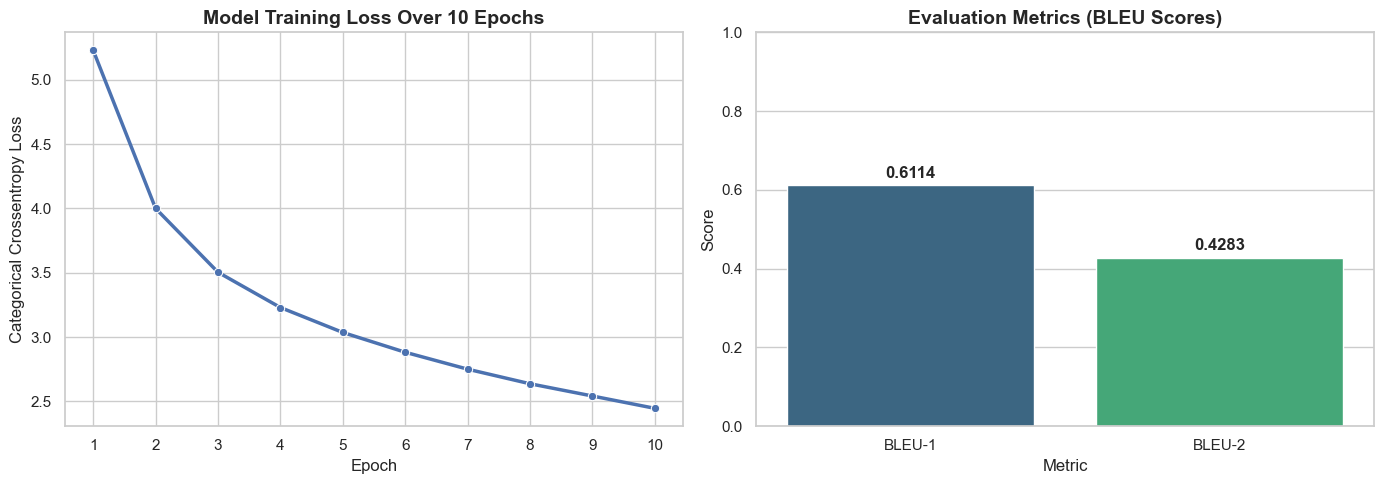


Cell 8 Complete: Visualizations rendered successfully!


In [10]:
# --- CELL 8: VISUALIZATIONS & METRICS ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Generating performance visualizations...")

# 1. Training Loss Data (Extracted from Cell 6 output)
epochs = np.arange(1, 11)
training_loss = [5.2302, 4.0004, 3.5040, 3.2297, 3.0357, 2.8818, 2.7502, 2.6368, 2.5415, 2.4457]

# 2. BLEU Score Data (Extracted from Cell 7 output)
bleu_labels = ['BLEU-1', 'BLEU-2']
bleu_scores = [0.611365, 0.428349]

# Set up the matplotlib figure layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.set_theme(style="whitegrid")

# Plot 1: Training Loss Curve
sns.lineplot(x=epochs, y=training_loss, marker='o', color='b', ax=axes[0], linewidth=2.5)
axes[0].set_title('Model Training Loss Over 10 Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Categorical Crossentropy Loss', fontsize=12)
axes[0].set_xticks(epochs)

# Plot 2: BLEU Scores Bar Chart
sns.barplot(x=bleu_labels, y=bleu_scores, palette='viridis', ax=axes[1], hue=bleu_labels, legend=False)
axes[1].set_title('Evaluation Metrics (BLEU Scores)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Metric', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_ylim(0, 1.0)

# Add data labels to the top of the bar chart
for i, v in enumerate(bleu_scores):
    axes[1].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

# Adjust layout and display
plt.tight_layout()
plt.show()

print("\nCell 8 Complete: Visualizations rendered successfully!")

In [15]:
# --- CELL 9: DEMO INTERFACE (GRADIO) ---
import gradio as gr
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

print("Building the Fast COCO Demo Interface...")

# 1. The function that runs when you upload an image
def generate_caption_for_ui(uploaded_image):
    # Step A: Preprocess for MobileNetV2 (Must be 224x224!)
    img = uploaded_image.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Step B: Extract the 1280-dimensional feature using MobileNetV2
    feature = encoder_model.predict(img_array, verbose=0)
    
    # Step C: Generate the caption using our trained LSTM
    generated_text = predict_caption(model, feature, tokenizer, max_length)
    
    # Capitalize the first letter and add a period
    if generated_text:
        generated_text = generated_text.capitalize() + "."
    else:
        generated_text = "Could not generate a caption."
        
    return generated_text

# 2. Build the Web App UI (Gradio 4.x Safe)
demo = gr.Interface(
    fn=generate_caption_for_ui,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Textbox(label="AI Generated Caption"),
    title="⚡ Team Project: Fast COCO Image Captioner",
    description="Upload an image! This model uses MobileNetV2 and an LSTM trained on a targeted subset of MS COCO for high accuracy.",
    theme="default",
    flagging_mode="never" 
)

# 3. Launch the App
print("\n✅ Interface Ready! Click the local URL below to open your web app.")
demo.launch(share=True)

Building the Fast COCO Demo Interface...


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\gradio\interface.py:171: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme. Please pass these parameters to launch() instead.
  super().__init__(



✅ Interface Ready! Click the local URL below to open your web app.
* Running on local URL:  http://127.0.0.1:7865
* Running on public URL: https://b2a524813fd80dfcdf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
